In [ ]:
#| default_exp regress_ml

# Train ML model

In [1]:
#|hide
from nbdev.showdoc import *

In [6]:
#|hide
#|export
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split #, RandomizedSearchCVcore
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from ML_projects import const_vals as CONST
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import warnings
warnings.filterwarnings('ignore')

In [3]:
#|export 
class TrainRegression():
       
       def __init__(self,
               df_path : str , # path to dataframe to be used to train. File should be CSV file
               requested_model : str , # model to train. Options : 'RFR' 'XGB' 'SVR' 'RIDGE' 'KNEIGHBORS' 'GRADIENT_BOOST' 'ADA'
               ground_truth_col: str, # name of the column with true data to train
               test_size : float , #size of data to be used for test 
               hyper_method : str , #hyperparameter tunning method. accepts : 'randomized' 'bayesian' , 'bayesian continous'
               columns_to_remove : list[str]=None , #columns not to use for trainning the model. These columns will be removed.
               ):
             self.df_path = df_path
             self.columns_to_remove = columns_to_remove
             self.ground_truth_col = ground_truth_col
             self.test_size = test_size
             self.hyper_method = hyper_method
             self.model_str = requested_model
             self.model_name = requested_model

             #load data and get train test data
             self.x_train, self.x_test, self.y_train, self.y_test = self._load_df_split_data()
             
             # create initial model and match the params 

             self.model , self.params = self._match_models_()

             #hyperparameter tunning
             self.best_params = self.hyperparameter()

             #train best model 

             self.best_model = self._create_best_model()

             #fit model

             self.best_model.fit(self.x_train, self.y_train)

             # Model evaluation
             self.evaluate_model()
       

       def _match_models_(self):
            self.model = CONST.algorithm_to_model[self.model_str]
            self.params = CONST.algorithm_to_params[self.model_str]

            return self.model , self.params

       def _load_df_split_data(self):
               
               self.df = pd.read_csv(self.df_path)
               #load dataframe
               if self.columns_to_remove!= None:
                     self.df = self.df.drop(self.columns_to_remove,axis=1)
          
               # split to x,y and train test data
               self.x = self.df.drop(self.ground_truth_col,axis=1)
               self.y = self.df[self.ground_truth_col].values

               #split data to train and test
               self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                      self.x, self.y, test_size=self.test_size, random_state=42)

               return self.x_train, self.x_test, self.y_train, self.y_test
       

       def hyperparameter(self):
             if self.hyper_method == 'randomized':
                   rf_random = RandomizedSearchCV(estimator = self.model, 
                                                  param_distributions = self.params,
                                                  n_iter = CONST.N_ITERATIONS_RFR,
                                                  cv = CONST.CV_RFR, 
                                                  verbose=CONST.VERBOSE , 
                                                  random_state=CONST.RANDOM_STATE , 
                                                  n_jobs = CONST.N_JOBS)
                   
                   #fit model 
                   rf_random.fit(self.x_train, self.y_train)

                  #best params
                   self.best_params = rf_random.best_params_


             elif self.hyper_method == 'bayesian':
                  rf_bayes = BayesSearchCV(self.model,
                                           search_spaces=self.params, 
                                           n_iter=CONST.N_ITERATIONS_RFR, 
                                           cv=CONST.CV_RFR)
                  np.int = int
      
                  #fit model 
                  rf_bayes.fit(self.x_train, self.y_train)

                  self.best_params = rf_bayes.best_params_

                  print(f'best params : {rf_bayes.best_params_}')


             return self.best_params
       
       def _create_best_model(self):
             if self.model_str == 'RFR':
                   self.best_model = RandomForestRegressor(**self.best_params)
            
             elif self.model_str == 'XGB':
                   self.best_model =xgb.XGBRegressor(**self.best_params)
             
             elif self.model_str == 'SVR':
                   self.best_model = SVR(**self.best_params)

             elif self.model_str == 'RIDGE':
                   self.best_model = Ridge(**self.best_params)
            
             elif self.model_str == 'KNEIGHBORS':
                   self.best_model = KNeighborsRegressor(**self.best_params)

             elif self.model_str == 'GRADIENT_BOOST':
                   self.best_model = GradientBoostingRegressor(**self.best_params)

             elif self.model_str == 'ADA':
                   self.best_model = AdaBoostRegressor(**self.best_params)

             return self.best_model
       
       def evaluate_model(self):
             
            # Make predictions
            y_pred = self.best_model.predict(self.x_test)

            # Calculate R2 score
            r2 = r2_score(self.y_test, y_pred)

            # Calculate MAE
            mae = mean_absolute_error(self.y_test, y_pred)

            # Calculate MSE
            mse = mean_squared_error(self.y_test, y_pred)

            # Calculate RMSE
            rmse = np.sqrt(mse)

            # Calculate MAPE
            mape = np.mean(np.abs((self.y_test - y_pred) / self.y_test)) * 100

            # Plotting predictions vs. ground truth
            plt.figure(figsize=(8, 6))
            plt.scatter(self.y_test, y_pred, color='blue', alpha=0.5)
            plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'k--', lw=2)
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title(f'Actual vs. Predicted - {self.model_name}')
            plt.grid(True)


                        # create a list with two empty handles (or more if needed)
            handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                          lw=0, alpha=0)] * 2

            # create the corresponding number of labels (= the text you want to display)
            labels = []
            labels.append("R2 = {0:.4g}".format(r2))
            labels.append("MAE = {0:.4g}".format(mae))

            plt.legend(handles, labels, loc='best', fontsize='small', 
                       fancybox=True, framealpha=0.7, 
                       handlelength=0, handletextpad=0)

            plt.show()


            # # Create scatter plot
            # plt.scatter(self.y_test, y_pred, color='blue', label='True vs Predicted')

            # # Add labels and title
            # plt.xlabel('True Values')
            # plt.ylabel('Predicted Values')
            # plt.title(f'True vs Predicted Values Scatter Plot - {self.model_name}')
            # plt.legend()

            # # Show plot
            # plt.grid(True)
            # plt.show()

            # Print evaluation metrics
            print("R2 Score:", r2)
            print("Mean Absolute Error:", mae)
            print("Mean Squared Error:", mse)
            print("Root Mean Squared Error:", rmse)
            print("Mean Absolute Percentage Error:", mape)

            #feature importance
            importance_scores = self.best_model.feature_importances_
            feature_names = self.x_test.columns.tolist()

                  # Plot feature importance
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names, importance_scores)
            plt.xlabel(f'Feature Importance Score - {self.model_name} ')
            plt.ylabel('Features')
            plt.title('Feature Importance')
            plt.show()

                  
            


best params : OrderedDict([('bootstrap', True), ('max_depth', 17), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 500)])


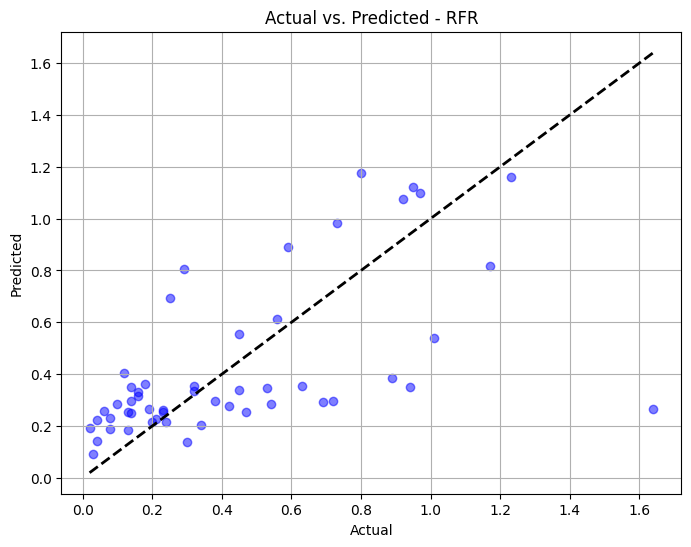

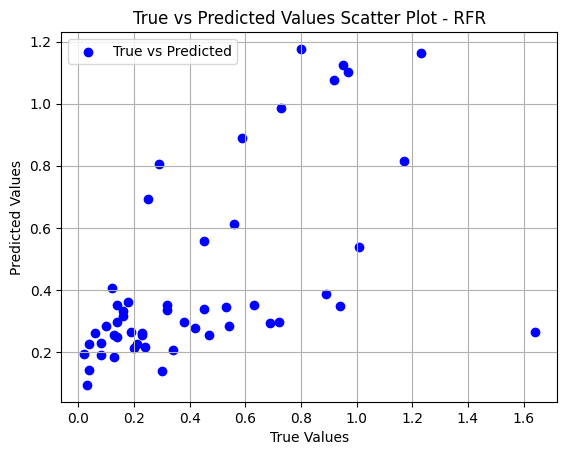

R2 Score: 0.3135696831806517
Mean Absolute Error: 0.213822018009768
Mean Squared Error: 0.09221142875547653
Root Mean Squared Error: 0.30366334773145826
Mean Absolute Percentage Error: 97.86004089586329


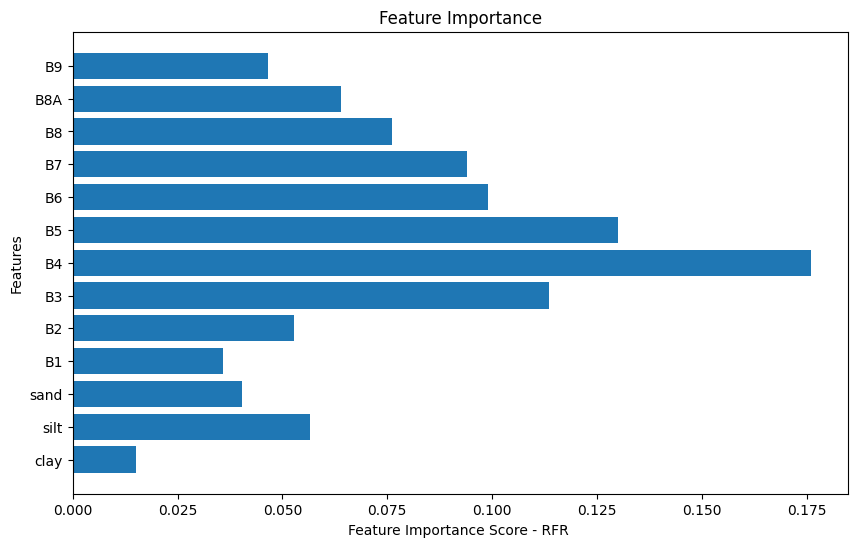

In [4]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
  requested_model= 'RFR',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
  hyper_method = 'bayesian'    
  )


best params : OrderedDict([('alpha', 0.5), ('colsample_bytree', 0.9), ('gamma', 0.01), ('learning_rate', 0.1), ('n_estimators', 100), ('subsample', 0.6)])


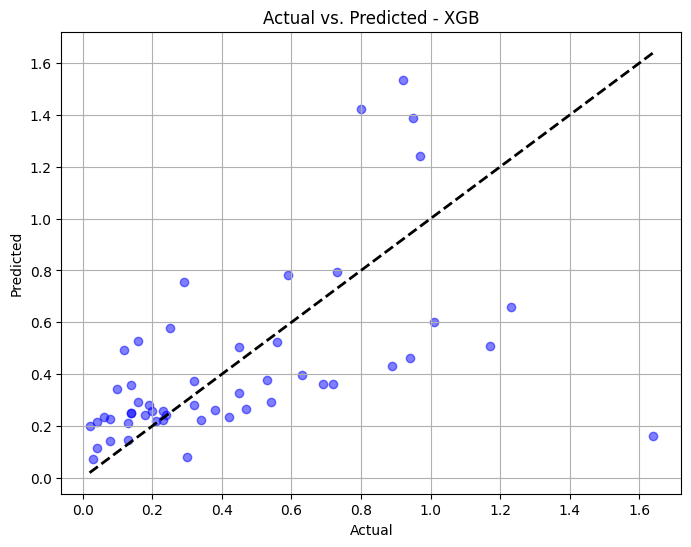

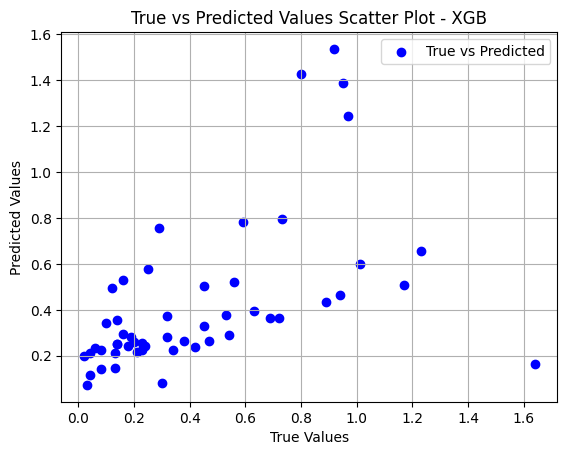

R2 Score: 0.13102345815035676
Mean Absolute Error: 0.23613372937417945
Mean Squared Error: 0.11673372593774424
Root Mean Squared Error: 0.3416631761512268
Mean Absolute Percentage Error: 96.17300132317665


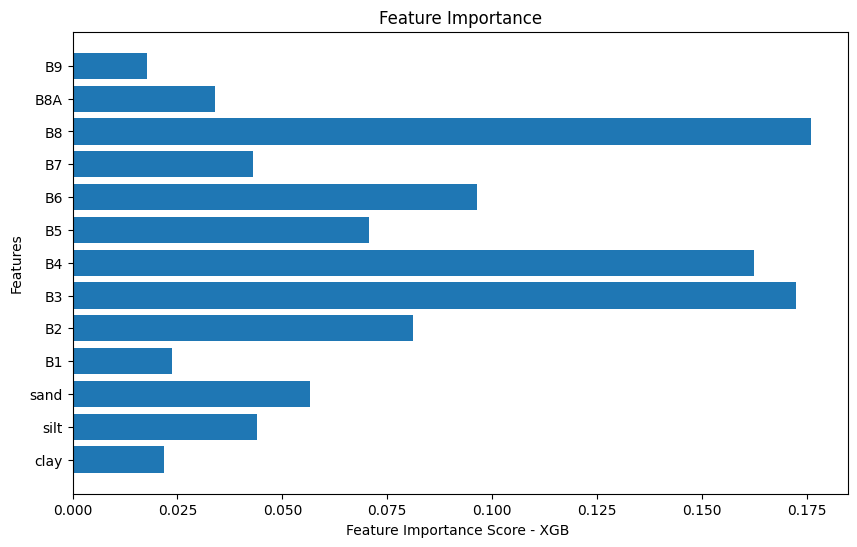

In [5]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
  requested_model= 'XGB',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
  hyper_method = 'bayesian'    
  )

In [ ]:
# instance = TrainRegression(
#   df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
#   requested_model= 'SVR',
#   ground_truth_col = "TOC",
#   test_size = 0.25,
#   columns_to_remove = ['Unnamed: 0.1', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
#   hyper_method = 'bayesian'    
#   )

In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
  requested_model= 'RIDGE',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
  hyper_method = 'bayesian'    
  )

In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
  requested_model= 'KNEIGHBORS',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
  hyper_method = 'bayesian'    
  )

In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
  requested_model= 'GRADIENT_BOOST',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
  hyper_method = 'bayesian'    
  )

In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2_v2.csv",
  requested_model= 'ADA',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1','Unnamed: 0.2', 'Unnamed: 0', 'Lon', 'Lat', 'NI'],
  hyper_method = 'bayesian'    
  )

In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2.csv",
  requested_model= 'RFR',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1', 'Unnamed: 0', 'Lon', 'Lat', 'clay', 'silt','sand', 'NI'],
  hyper_method = 'bayesian'    
  )



In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2.csv",
  requested_model= 'XGB',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1', 'Unnamed: 0', 'Lon', 'Lat', 'clay', 'silt','sand', 'NI'],
  hyper_method = 'bayesian'    
  )

In [ ]:
instance = TrainRegression(
  df_path=r"D:\git\ML_projects\nbs\data\resampled_sen2.csv",
  requested_model= 'KNEIGHBORS',
  ground_truth_col = "TOC",
  test_size = 0.25,
  columns_to_remove = ['Unnamed: 0.1', 'Unnamed: 0', 'Lon', 'Lat', 'clay', 'silt','sand', 'NI'],
  hyper_method = 'bayesian'    
  )